In [1]:
import re
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt  
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from tqdm import tqdm
from nltk.corpus import stopwords
stopwordEn = stopwords.words('english')
import pickle
import os

import multiprocessing as mp
import numpy as np
import time
print('CPU numbers:',mp.cpu_count())
def _apply_df(args):
    df, func, kwargs = args
    return df.apply(func, **kwargs)

def apply_by_multiprocessing(df, func, **kwargs):
#     print(kwargs)
    workers = kwargs.pop('workers')
    pool = mp.Pool(processes=workers)
    result = pool.map(_apply_df, [(d, func, kwargs) for d in np.array_split(df, workers)])
    pool.close()
    return pd.concat(list(result))
#apply_by_multiprocessing(fullset['Text'], process_text, workers=cores)

def processText(text,lemma=False, gram=1):
    text = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b|@\w+|#', '', text, flags=re.MULTILINE) #delete URL, #hashtag# , and @xxx
    tokens = word_tokenize(text)
    whitelist = ["n't", "not", "no"]
    tokens = [lemmaWord(i.lower()) if lemma else i.lower() for i in tokens if (i.lower() not in stopwordEn or i.lower() in whitelist) and i.isalpha()]
    if gram<=1:
        return tokens
    else:
        return [' '.join(i) for i in nltk.ngrams(tokens, gram)]

CPU numbers: 32


In [2]:
with open('tweets_processed.pickle', 'rb') as handle:
    df = pickle.load(handle)
df.head()

,airline_sentiment,airline_sentiment_confidence,text
0,0,1.0000,[said]
1,1,0.3486,"[plus, added, commercials, experience, tacky]"
2,0,0.6837,"[today, must, mean, need, take, another, trip]"
3,-1,1.0000,"[really, aggressive, blast, obnoxious, enterta..."
4,-1,1.0000,"[really, big, bad, thing]"


In [3]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
t = Tokenizer(num_words=None) #设置为None则使用全部词语，若设置数字N，则在后续Text2Seq时只考虑TopN的词汇
t.fit_on_texts(df.text) # 根据给出的text训练tokenizer, 本质上是构建一个记录词频的字典

print(list(t.word_index.keys())[:10]) #自动根据词频高到低排序，index从小到大，这里显示所有的词语，与Tokenizer的num_words无关

vocab_size = len(t.word_index) + 1
print(vocab_size)
docs_seq = t.texts_to_sequences(df.text)

['flight', 'not', 'no', 'get', 'thanks', 'cancelled', 'service', 'help', 'time', 'customer']
10696


# GloVe

## Pre-Trained GloVe Embedding
https://nlp.stanford.edu/projects/glove/
pure weights, no model, hard to find nearest neighbors 

In [6]:
# load the whole embedding into memory
embeddings_dict = {}
with open("../Pretrained_WE/glove.twitter.27B.25d.txt", 'r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        if len(vector)==25:
            embeddings_dict[word] = vector
print('Loaded %s word vectors.' % len(embeddings_dict))

Loaded 1193513 word vectors.


In [7]:
from scipy import spatial
spatial.distance.euclidean(embeddings_dict['prime'], embeddings_dict['minister'])

3.0760934352874756

In [8]:
words =  list(embeddings_dict.keys())
vectors = np.array([embeddings_dict[word] for word in words])

### PCA-Glove-100-2

In [6]:
from sklearn.decomposition import PCA
vectors_2d = PCA(n_components=2, random_state=0).fit_transform(vectors)
dict_emb_2g = dict(zip(words,vectors_2d))

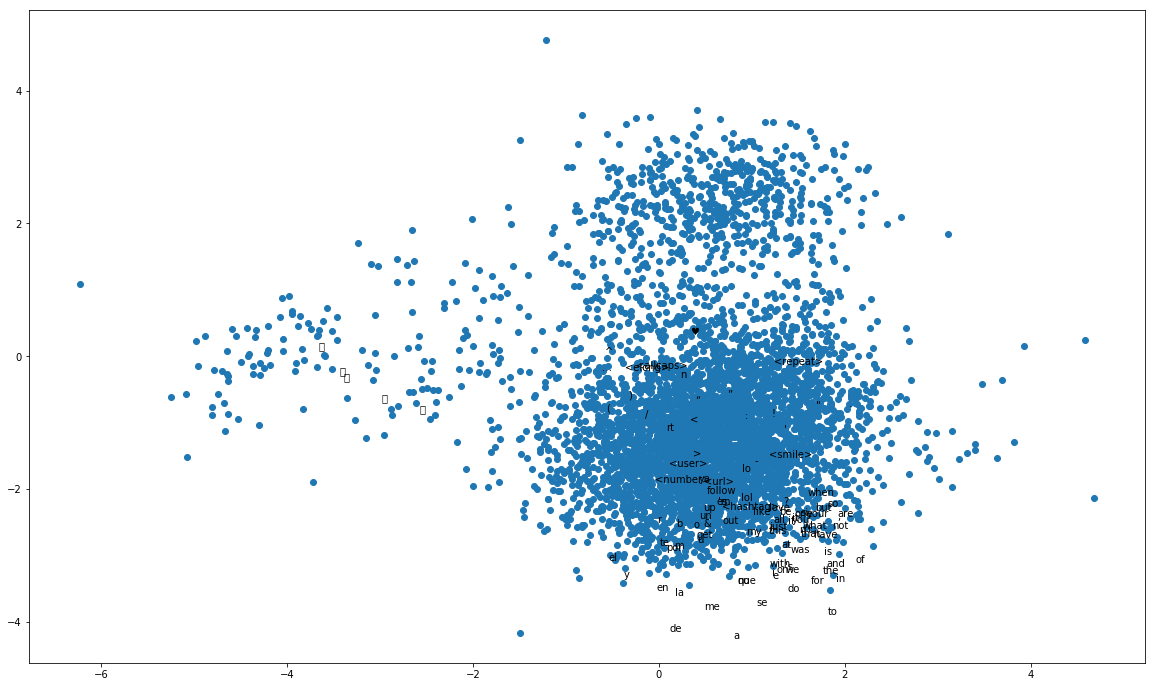

In [58]:
w_s = 0
w_e = 100
w_range = range(10000,15000)
plt.rcParams["figure.figsize"] = (20, 12)
plt.scatter(vectors_2d[w_range, 0], vectors_2d[w_range, 1])
for label, x, y in zip(words[w_s:w_e], vectors_2d[w_s:w_e, 0], vectors_2d[w_s:w_e, 1]):
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords="offset points")
plt.show()

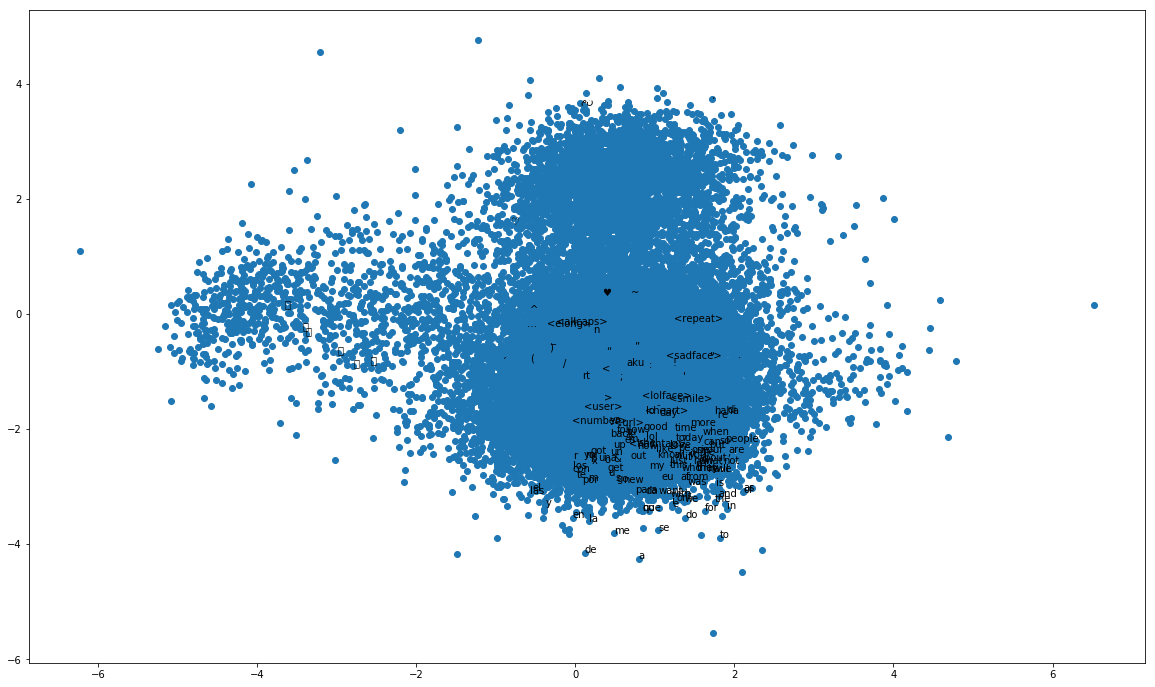

In [59]:
# np.random.seed(0)
# subset_words = np.random.choice(words, size = 500 ,replace=False)
plt.scatter(vectors_2d[:30000, 0], vectors_2d[:30000, 1])
for w in words[:150]:
    plt.text(dict_emb_2g[w][0], dict_emb_2g[w][1], w)
plt.rcParams["figure.figsize"] = (20, 12)
# plt.xlim(-10, 10)
# plt.ylim(-10, 10)
plt.show() 

### TSNE-Glove-100-2

In [60]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0).fit_transform(vectors[:2000]) 

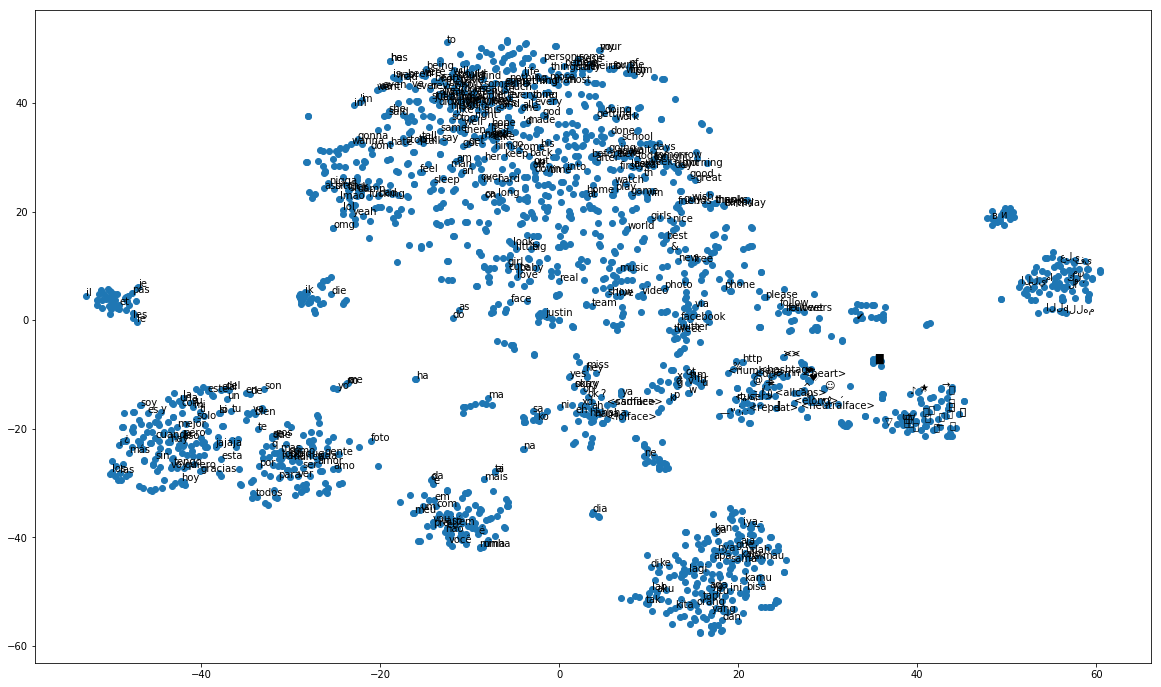

In [63]:
w_s = 0
w_e = 500
w_range = range(0,2000)
plt.rcParams["figure.figsize"] = (20, 12)

plt.scatter(tsne[w_range, 0], tsne[w_range, 1])
for label, x, y in zip(words[w_s:w_e], tsne[w_s:w_e, 0], tsne[w_s:w_e, 1]):
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords="offset points")

plt.show() 

## Own GloVe
无法安装glove包，且还需要coocurence共现矩阵

In [ ]:
# 使用自己的语料库训练Glove
# https://pypi.org/project/glove/
from glove import Corpus, Glove

#Creating a corpus object
corpus = Corpus() 

#Training the corpus to generate the co occurence matrix which is used in GloVe
corpus.fit(lines, window=10)

glove = Glove(no_components=5, learning_rate=0.05) 
glove.fit(corpus.matrix, epochs=30, no_threads=4, verbose=True)
glove.add_dictionary(corpus.dictionary)
glove.save('glove.model')

# Word2Vec

## Pre-trained Word2Vec

## Own Word2Vec

In [18]:
from gensim.models import Word2Vec
model_w2c = Word2Vec(df.text, size=100, window=10, min_count=1, workers=16, seed=0)
subset = model_w2c.wv.index2word
print(len(subset))

vectors = []
for w in subset:
    vectors.append(model_w2c.wv[w])

10695


In [19]:
from sklearn.decomposition import PCA
vectors_2d = PCA(n_components=2).fit_transform(vectors) # 能否直接fit(model.wv)?

In [20]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0).fit_transform(vectors[:1000]) #使用tsne区别？

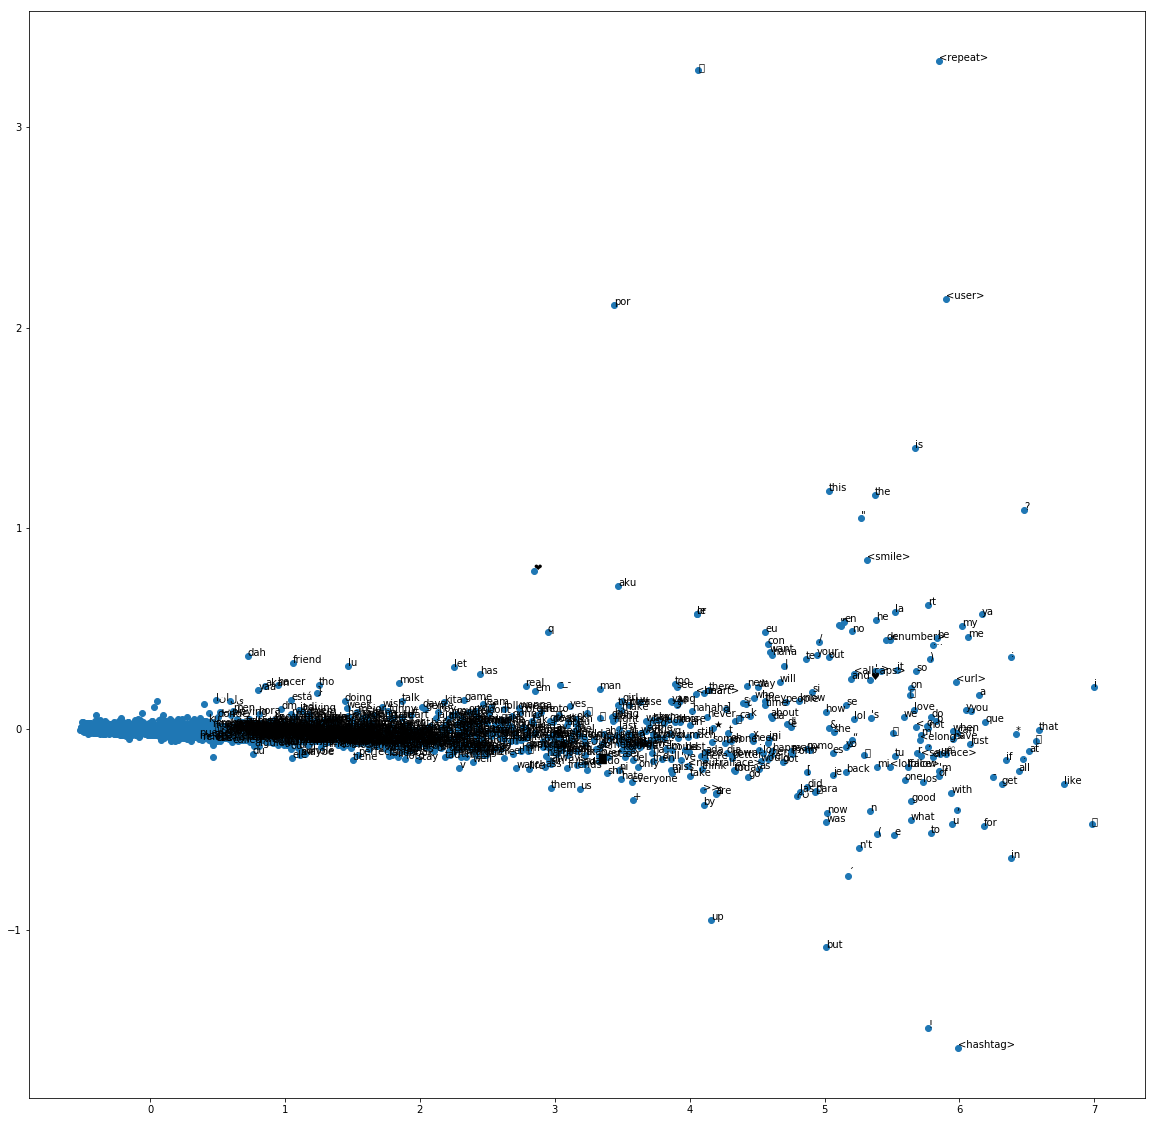

In [32]:
w_s = 0
w_e = 1000
w_range = range(0,10695)
plt.rcParams["figure.figsize"] = (20, 20)
plt.scatter(vectors_2d[w_range, 0], vectors_2d[w_range, 1])
for label, x, y in zip(words[w_s:w_e], vectors_2d[w_s:w_e, 0], vectors_2d[w_s:w_e, 1]):
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords="offset points")
plt.show()

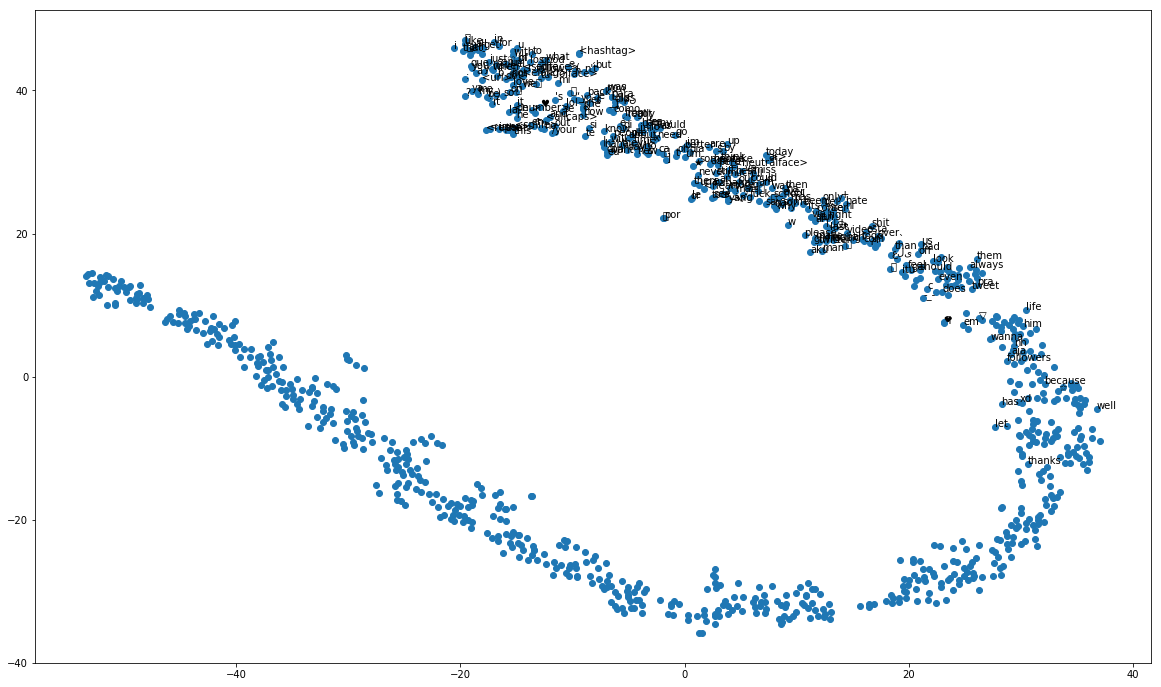

In [36]:
w_s = 0
w_e = 300
w_range = range(0,1000)
plt.rcParams["figure.figsize"] = (20, 12)

plt.scatter(tsne[w_range, 0], tsne[w_range, 1])
for label, x, y in zip(words[w_s:w_e], tsne[w_s:w_e, 0], tsne[w_s:w_e, 1]):
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords="offset points")

plt.show() 

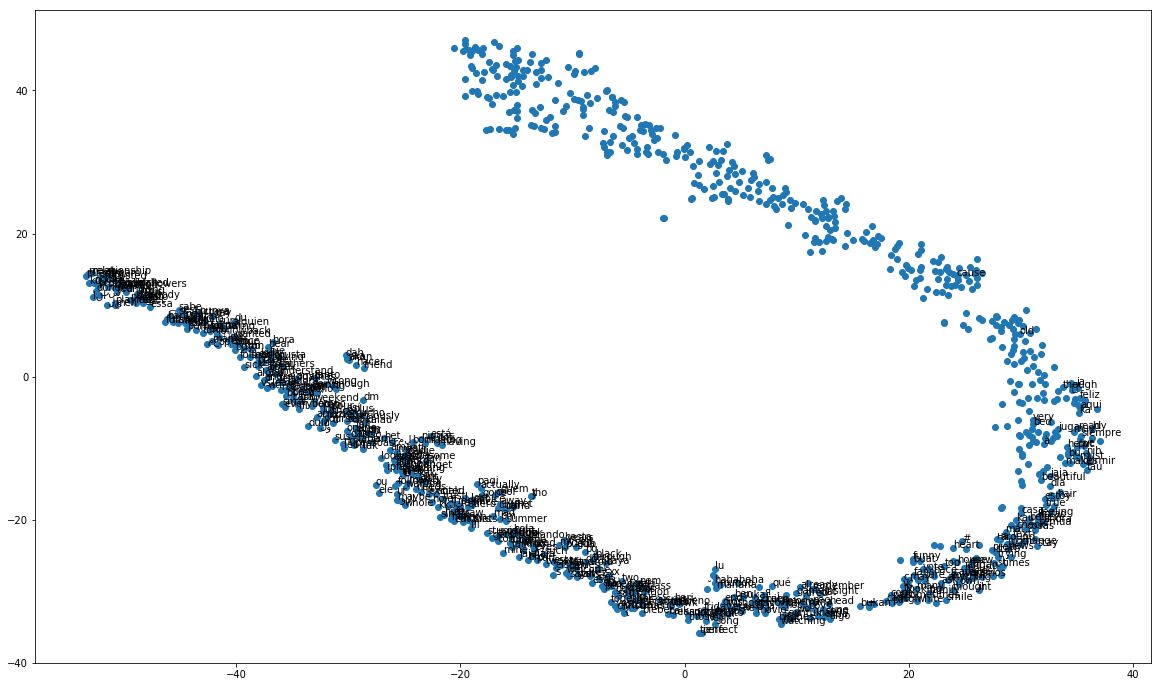

In [40]:
w_s = 500
w_e = 1000
w_range = range(0,1000)
plt.rcParams["figure.figsize"] = (20, 12)

plt.scatter(tsne[w_range, 0], tsne[w_range, 1])
for label, x, y in zip(words[w_s:w_e], tsne[w_s:w_e, 0], tsne[w_s:w_e, 1]):
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords="offset points")

plt.show() 